In [117]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pointbiserialr

In [118]:
df = pd.read_csv("eth_hourly_data.csv") 

In [119]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')  # coerce invalid strings to NaT
df.head()

,time,low,high,open,close,volume
0,2024-03-23 23:00:00+00:00,3328.61,3379.81,3377.48,3330.05,3976.683563
1,2024-03-24 00:00:00+00:00,3328.02,3359.31,3330.28,3357.61,1568.203206
2,2024-03-24 01:00:00+00:00,3346.50,3368.64,3357.77,3351.72,1410.311368
3,2024-03-24 02:00:00+00:00,3339.02,3357.28,3351.93,3344.86,1618.462267
4,2024-03-24 03:00:00+00:00,3308.26,3344.90,3344.85,3309.35,3822.079261


In [120]:
# --- Price Spreads & Candlestick Features ---
df['high_low_pct'] = (df['high'] - df['low']) / df['open']
df['open_close_pct'] = (df['close'] - df['open']) / df['open']
df['candle_direction'] = np.sign(df['close'] - df['open'])
df['upper_shadow'] = (df['high'] - df[['open', 'close']].max(axis=1)) / df['open']
df['lower_shadow'] = (df[['open', 'close']].min(axis=1) - df['low']) / df['open']

# --- Returns & Momentum ---
df['return_1'] = df['close'].pct_change(1)
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df['momentum_3'] = df['close'] - df['close'].shift(3)
df['roc_3'] = df['close'].pct_change(3)

# --- Moving Averages ---
df['sma_3'] = df['close'].rolling(3).mean()
df['sma_5'] = df['close'].rolling(5).mean()
df['ema_5'] = df['close'].ewm(span=5).mean()

# --- Volatility ---
df['volatility_5'] = df['close'].rolling(5).std()
df['tr'] = df[['high', 'low', 'close']].apply(lambda row: max(
    row['high'] - row['low'],
    abs(row['high'] - row['close']),
    abs(row['low'] - row['close'])
), axis=1)
df['atr_5'] = df['tr'].rolling(5).mean()

# --- Volume Features ---
df['volume_change'] = df['volume'].pct_change(1)
df['volume_price_ratio'] = df['volume'] / df['close']
df['volume_rolling_5'] = df['volume'].rolling(5).mean()
df['volume_spike'] = df['volume'] > 1.5 * df['volume_rolling_5']

# --- Time Features ---
df['hour'] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek
df['is_weekend'] = df['dayofweek'] >= 5

# --- Rolling Extremes & Z-Scores ---
df['rolling_max_5'] = df['close'].rolling(5).max()
df['rolling_min_5'] = df['close'].rolling(5).min()
df['position_in_range'] = (df['close'] - df['rolling_min_5']) / (df['rolling_max_5'] - df['rolling_min_5'])
df['zscore_close_5'] = (df['close'] - df['sma_5']) / df['volatility_5']

# --- Future Price Movement Classification Target ---
future_close = df['close'].shift(-3)  # Predicting 3 steps ahead
future_return = (future_close - df['close']) / df['close']
df['target'] = ((future_close - df['close']) / df['close']).apply(lambda x: 1 if x > 0 else 0)

# Drop rows with NaNs from rolling calculations
df.dropna(inplace=True)

In [121]:
threshold = 0.002  # 0.2% change, for example

df['future_close'] = df['close'].shift(-3)  # Predicting 3 steps ahead
delta = (df['future_close'] - df['close']) / df['close']
df['target'] = np.where(delta > threshold, 1, np.where(delta < -threshold, 2, 0))

In [122]:
feature_cols = [col for col in df.columns if col not in ['time', 'target', 'close', 'open', 'high', 'low', 'future_close', 'volume']]
X = df[feature_cols]
y = df['target']

In [123]:
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
print(class_counts)

{0: 2096, 1: 4003, 2: 3812}


In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [125]:
model = XGBClassifier(
    objective='binary:logistic',  # sigmoid + binary log loss
    eval_metric='logloss',
    use_label_encoder=False
)

model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [126]:
y_pred_probs = model.predict_proba(X_test)
pred_classes = []
for y_pred_prob in y_pred_probs:
    prob_0 = y_pred_prob[0]
    prob_1 = y_pred_prob[1]
    prob_2 = y_pred_prob[2]
    max_prob = max(prob_0, prob_1, prob_2)
    if prob_0 == max_prob:
        pred_classes.append(0)
    if prob_1 == max_prob:
        pred_classes.append(1)
    if prob_2 == max_prob:
        pred_classes.append(2)

In [127]:
print("Classification Report:")
print(classification_report(y_test, pred_classes, target_names=['FLAT', 'UP', 'DOWN']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_classes))

Classification Report:
              precision    recall  f1-score   support

        FLAT       0.20      0.02      0.04       326
          UP       0.43      0.86      0.57       856
        DOWN       0.42      0.13      0.20       801

    accuracy                           0.43      1983
   macro avg       0.35      0.34      0.27      1983
weighted avg       0.39      0.43      0.33      1983

Confusion Matrix:
[[  8 277  41]
 [ 23 732 101]
 [  9 689 103]]


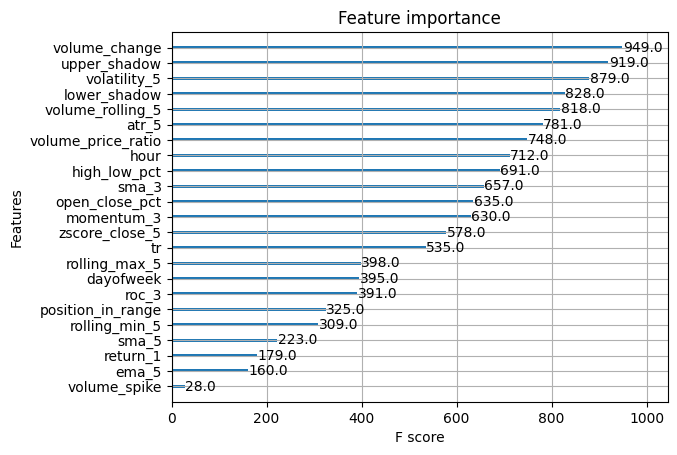

In [128]:
plot_importance(model)
plt.show()

In [129]:
# Filter valid rows
df_clean = df.dropna(subset=feature_cols + ['target'])

In [130]:
for col in feature_cols:
    corr, pval = pointbiserialr(df_clean[col], df_clean['target'])
    print(f"{col:<25} r = {corr:.3f} | p = {pval:.2e}")

# Mutual Information
X = df_clean[feature_cols]
y = df_clean['target']
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=0)

print("\nMutual Information with 'direction':")
for score, col in sorted(zip(mi_scores, feature_cols), reverse=True):
    print(f"{col:<25} MI = {score:.4f}")


high_low_pct              r = 0.069 | p = 4.44e-12
open_close_pct            r = 0.004 | p = 6.63e-01
candle_direction          r = 0.010 | p = 3.40e-01
upper_shadow              r = 0.043 | p = 2.13e-05
lower_shadow              r = 0.037 | p = 1.98e-04
return_1                  r = 0.004 | p = 6.65e-01
log_return                r = 0.004 | p = 7.03e-01
momentum_3                r = -0.003 | p = 7.81e-01
roc_3                     r = -0.002 | p = 8.72e-01
sma_3                     r = -0.016 | p = 1.21e-01
sma_5                     r = -0.015 | p = 1.26e-01
ema_5                     r = -0.015 | p = 1.23e-01
volatility_5              r = 0.061 | p = 1.28e-09
tr                        r = 0.068 | p = 1.04e-11
atr_5                     r = 0.074 | p = 2.04e-13
volume_change             r = 0.006 | p = 5.58e-01
volume_price_ratio        r = 0.048 | p = 1.58e-06
volume_rolling_5          r = 0.059 | p = 5.54e-09
volume_spike              r = 0.034 | p = 6.84e-04
hour                      